---
# Setup

### Imports

In [1]:
import numpy as np

from scipy.stats import multivariate_normal
from scipy.integrate import dblquad

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

**Documentation**

+ [scipy.integrate.dblquad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html)

+ [scipy.stats.multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html)

### Plot Functions

In [2]:

def plt_grid_data(rv1, rv2): 
    x = np.linspace(-3, 3, 500)
    y = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(x, y)
    Z1 = rv1.pdf(np.dstack((X, Y)))
    Z2 = rv2.pdf(np.dstack((X, Y)))
    return X, Y, Z1, Z2

def plt_distributions(X, Y, Z1, Z2): 
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    mask_1 = Z1 > Z2
    mask_2 = Z1 < Z2
    Z_max = np.where(mask_1, Z1, Z2)
    Z_min = np.where(mask_2, Z1, Z2)
    cmax = np.where(mask_1, 'tab:blue', 'tab:orange')
    cmin = np.where(mask_2, 'tab:blue', 'tab:orange')
    ax.plot_surface(X, Y, Z_max, facecolors=cmax,linewidth=1, alpha=0.5)
    ax.plot_surface(X, Y, Z_min, facecolors=cmin,linewidth=1, alpha=0.5)
    #ax.set_xticklabels([])  
    #ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.view_init(elev=20., azim=-40)
    plt.show()

def plt_decision_boundary(X, Y, Z1, Z2):
    cmap = ListedColormap(['tab:orange', 'tab:blue'])
    Z_bayes = np.where(Z1 >= Z2, 1, 0)
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(111)
    ax.contourf(X, Y, Z_bayes, cmap=cmap, alpha=0.5)
    #ax.set_xticklabels([])  
    #ax.set_yticklabels([])
    plt.show()

def plt_data(X, y, size=10):
    plt.scatter(*X[y==1].T, s=size, alpha=1, color='tab:blue', edgecolors='white')
    plt.scatter(*X[y==0].T, s=size, alpha=1, color='tab:orange', edgecolors='white')
    plt.show()

### Normal Distributions

In [3]:
# parameters of normal distributions
mu1 = np.array([-1, -1])
mu2 = np.array([+1, +1])
sigma1 = np.array([[2, 1/2], [1/2, 2]])
sigma2 = np.array([[1, 1], [1, 1.5]])

# normal density functions
rv1 = multivariate_normal(mu1, sigma1)
rv2 = multivariate_normal(mu2, sigma2)

### Distributions and Decision Regions

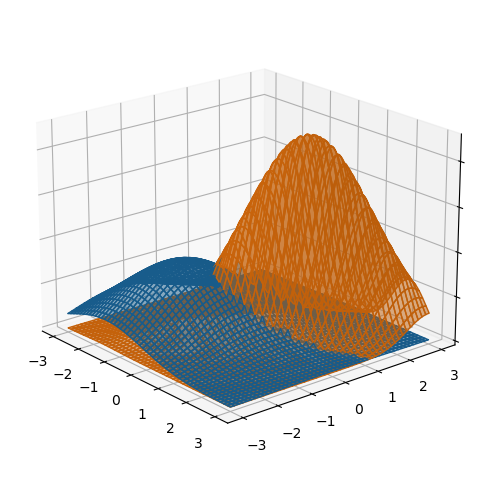

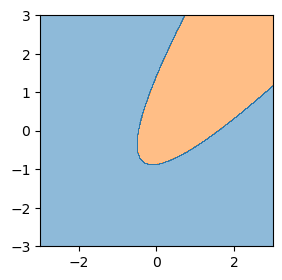

In [4]:
X, Y, Z1, Z2 = plt_grid_data(rv1, rv2)

plt_distributions(X, Y, Z1, Z2)
plt_decision_boundary(X, Y, Z1, Z2)

---
# Bayes Risk and Classifier

### Bayes Risk

In [5]:
def bayes_risk(rv1, rv2, eps=1e-01): 
    # prior: P(y=+1) = P(y=-1) = 0.5
    prior = 0.5 
    loss = lambda x, y: prior * np.minimum(rv1.pdf([x, y]), rv2.pdf([x, y]))
    risk, _ = dblquad(loss, -np.inf, np.inf, -np.inf, np.inf, epsabs=eps,epsrel=eps)
    return risk

In [6]:
exp_risk_bayes = bayes_risk(rv1, rv2)
print(f'Bayes risk: {exp_risk_bayes:.2f}') 

Bayes risk: 0.14


### Bayes Classifier

In [7]:
class BayesClassifier:
    def __init__(self, rv1, rv2):
        self.rv1 = rv1
        self.rv2 = rv2

    def predict(self, x):
        if self.rv1.pdf(x) >= self.rv2.pdf(x):
            return 1
        else:
            return 0

    def score(self, X, y):
        y_hat = (self.rv1.pdf(X) >= self.rv2.pdf(X)).astype(int)
        return np.mean(y_hat == y)

---
# Experiment

### Data

In [8]:
def sample(rv1, rv2, n):
    X1 = rv1.rvs(size=n)
    X2 = rv2.rvs(size=n)
    y1 = np.ones(n)
    y2 = np.zeros(n)
    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, y2))
    return X, y

def split(X, y, train_size=30):
    X_train, _, y_train, _ = train_test_split(X, y, train_size=train_size, stratify=y)
    return X_train, y_train

In [9]:
X, y = sample(rv1, rv2, 500000)
X_train, y_train = split(X, y, 20)

### Bayes Classifier

In [10]:
fB = BayesClassifier(rv1, rv2)
exp_risk_fB = 1. - fB.score(X, y)
print(f'risk of fB: {exp_risk_fB:.2f}') 

risk of fB: 0.14


### Logistic Regression on all Data

In [11]:
fH = LogisticRegression()
fH.fit(X, y)
exp_risk_fH = 1. - fH.score(X, y) 
print(f'risk of fH: {exp_risk_fH:.2f}') 

risk of fH: 0.18


### Logistic Regression on Training Data

In [27]:
n_sample = 5
n_trials = 3
results = np.zeros((n_trials, 4))
for i in range(n_trials):
    X_train, y_train = split(X, y, n_sample)
    fn = LogisticRegression()
    fn.fit(X_train, y_train)
    
    emp_risk_fn = 1. - fn.score(X_train, y_train) 
    exp_risk_fn = 1. - fn.score(X, y) 
    emp_risk_fH = 1. - fH.score(X_train,y_train)
    emp_risk_bayes = 1. - fB.score(X_train,y_train)
    results[i] = [emp_risk_fn, exp_risk_fn, emp_risk_fH, emp_risk_bayes]


### Output of Results

In [28]:
print(f'{"Rn(fn)":>7s}{"R(fn)":>7s}', end='  ')
print(f'{"Rn(fH)":>7s}{"R(fH)":>7s}', end='  ')
print(f'{"Rn(fB)":>7s}{"R(fB)":>7s}')
for res in results:
    print(f'{res[0]:7.2f}', end='')             # emp_risk_fn
    print(f'{res[1]:7.2f}', end='  ')           # exp_risk_fn
    print(f'{res[2]:7.2f}', end='')             # emp_risk_fH
    print(f'{exp_risk_fH:7.2f}', end='  ')      # exp_risk_fH
    print(f'{res[3]:7.2f}', end='')             # emp_risk_bayes
    print(f'{exp_risk_bayes:7.2f}', end='')     # exp_risk_bayes
    print()

print()
print('Estimation and Approximation Error')

print(f'{"R(fn) - R(fB)":^15s}', end='  ')
print(f'{"R(fn) - R(fH)":^15s}', end='  ')
print(f'{"R(fH) - R(fB)":^15s}')
for res in results:
    print(f'{res[1]-exp_risk_bayes:^15.2f}', end='  ') 
    print(f'{res[1]-exp_risk_fH:^15.2f}', end='  ') 
    print(f'{exp_risk_fH-exp_risk_bayes:^15.2f}') 

 Rn(fn)  R(fn)   Rn(fH)  R(fH)   Rn(fB)  R(fB)
   0.20   0.40     0.60   0.18     0.60   0.14
   0.20   0.22     0.20   0.18     0.20   0.14
   0.20   0.23     0.20   0.18     0.00   0.14

Estimation and Approximation Error
 R(fn) - R(fB)    R(fn) - R(fH)    R(fH) - R(fB) 
     0.27             0.22             0.04      
     0.09             0.04             0.04      
     0.10             0.06             0.04      
